## Required packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as stats
import seaborn as sns

from sklearn import tree
from sklearn.linear_model import LogisticRegression  
from sklearn.naive_bayes import GaussianNB  
from sklearn.neighbors import KNeighborsClassifier   
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from sklearn.inspection import plot_partial_dependence
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_gaussian_quantiles
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score  
from sklearn.model_selection import train_test_split
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from collections import Counter
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.inspection import permutation_importance
import pickle
import shap
from sklearn.metrics import roc_curve, auc
import matplotlib.cm as cm

## Define Functions for Machine Learning Model

In [2]:
def calc_metrics(y_test, preds):
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1score = f1_score(y_test, preds)
    return (accuracy, precision, recall, f1score)

def model_predict(model, x_train, y_train, x_test, y_test):
    model = model.fit(x_train, y_train)
    y_predict_train = model.predict(x_train)
    y_predict_test = model.predict(x_test)
    return accuracy_score(y_predict_train, y_train), accuracy_score(y_predict_test, y_test), y_predict_test

def sort_feature(feature_names, feature_vals):
    assert len(feature_names) == len(feature_vals)
    x_and_y = [(x, y) for x, y in zip(feature_names, feature_vals)]
    x_and_y.sort(key = lambda x: -x[1])
    return [item[0] for item in x_and_y], [item[1] for item in x_and_y]

def get_feature_importance(model, x_test, y_test):
    perm_importance = permutation_importance(model, x_test, y_test)
    perm_sorted_idx = perm_importance.importances_mean.argsort()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)
    return (model.feature_importances_, perm_sorted_idx, shap_values)

## LightGBM Machine Learning Algorithms

In [3]:
def machine_learning(x, y, split_ratio=0.3, random_seed=28):
    xstd = x.std()
    xmean = x.mean()
    
    x = (x - x.mean()) / x.std()
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = split_ratio, random_state = random_seed, shuffle = True)
    xtestvalue = x_test * xstd + xmean
    
    map = {}

    # LightGBM
    print("Starting LightGBM。。。")
    time1 = time.time()
    gbm = lgb.LGBMClassifier(random_state=random_seed)
    score_train, score_test, y_predict_test = model_predict(gbm, x_train, y_train, x_test, y_test)
    y_pred_proba = gbm.predict_proba(x_test)[:,1]
    
    dt_featureimprotance, permsortedidx, shapevalues = get_feature_importance(gbm, x_test, y_test)
    
    map['LightGBM'] = (dt_featureimprotance, permsortedidx, xstd, xmean, xtestvalue, shapevalues, x_test, y_test, y_pred_proba)

    calc_metrics(y_test, y_predict_test)

    return map

## Load Dataset 

In [4]:
result_map = {}

df = pd.read_csv('./414188yidan.csv')
df_src = df[['gender', 'age', 'siblings', 'bo', 'grade', 'sfsc', 'OBSES', 'chat',
             'care0', 'care1', 'care2','care3','care4','care5','care6','care7','care8',
             'Sregion', 'Stype', 'sssc', 'friends', 'sport', 'screen', 'game', 'video', 'book', 'ecf', 
             'BMI', 'DEP', 'PEI', 'NEI', 'SWLS', 'PMH', 'hos1', 'hos2', 'myopia', 'ST', 
             'drink', 'smoke', 'shs']].astype(float)

df_tgt = df[['traditional_any_alt']]
print("Data prepare done")

for i in range(1):
    result_map[i] = machine_learning(df_src, df_tgt.values.ravel(), random_seed=i)

Data prepare done
Starting LightGBM。。。


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


## SHAP Summary Plot

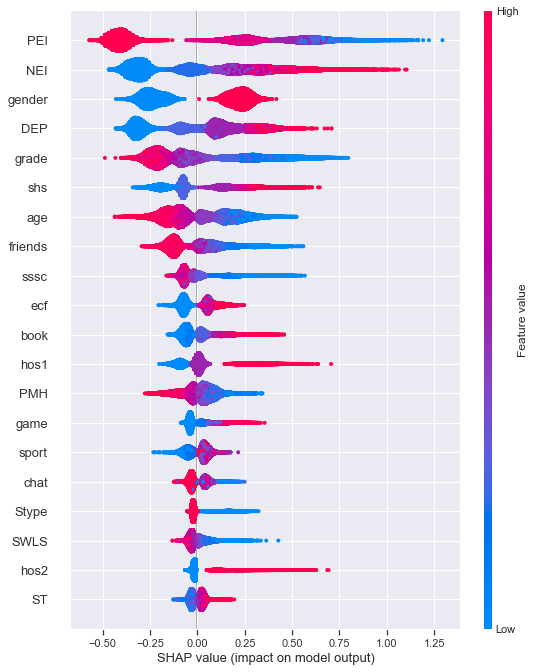

In [6]:
for model_name, vals in result_map[0].items():
    shap.summary_plot(vals[-4][1], vals[-5])

import seaborn as sns

sns.set_theme(style="darkgrid")